# Sampling distributions

## Preliminaries

In [1]:
import altair as alt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
import statistics
import types

from scipy.stats import truncnorm
from typing import Callable

np.random.seed(141)

In [2]:
def calculate_bootstrapped_sampling_statistic(
    observed_sample: npt.NDArray,
    summarising_fn: Callable[[npt.NDArray], float]
) -> float:
    """
    This is a higher-order function that performs one iteration of a bootstrap.
    It is designed to take Numpy summary functions as its `summarising_fn`
    argument, such as `np.mean()`, `np.median()` and `np.var()`.

    I have left this function outside `get_sampling_distribution` so that users
    can manually perform single bootstrap iterations on demand.
    """
    bootstrapped_sample = np.random.choice(observed_sample, size=observed_sample.size, replace=True)
    return float(summarising_fn(bootstrapped_sample))

In [3]:
def get_sampling_distribution(
    input_sample: npt.NDArray,
    size: int,
    summarising_fn: Callable[[npt.NDArray], float]  # First element refers to arguments; second element refers to return value
) -> list[float]:
    """
    This is a higher-order function. It is designed to take Numpy summary
    functions as its `summarising_fn` argument. Examples include `np.mean()`,
    `np.median()` and `np.var()`.
    
    `size` refers to the desired size of the sampling distribution.
    """
    output = []

    for i in range(0, size):
        sampling_statistic = calculate_bootstrapped_sampling_statistic(input_sample, summarising_fn)
        output.append(sampling_statistic)

    return output

In [4]:
# Allows for offline rendering of visualisations, so that they can be visible
# on GitHub. Otherwise, the default JavaScript visualisations that Altair
# generates will not be executed for security reasons. See here:
# https://stackoverflow.com/questions/71346406/why-are-my-altair-data-visualizations-not-showing-up-in-github

# Make sure to install vl-convert-python for PNG to work!
alt.renderers.enable('png')

RendererRegistry.enable('png')

## Introduction

We calculate sampling statistics to summarise the information contained in our sample data. For instance, we calculate the sample mean to get the average of all the values in some sample. However, we also need to be sure that our sampling statistic is _accurate_. This is what we need the sampling distribution for: it is a tool that helps us quantify our uncertainty about our observed sampling statistic.

The sampling distribution is the probability distribution of a sampling statistic, such as the sample mean mentioned above, but it could also be a sample median or variance. (Think of a theoretical distribution where a value on the _x_-axis represents one sample mean.)

Assuming we have a sample that is **representative** of the wider population, we can calculate a sampling statistic that, at first glance, appears to estimate a corresponding value for the entire population. In the case of the sample mean, we think of it as an estimate of the population mean. (The general label for the population mean, median and so on is _population parameter_.)

How sure are we that the sample and population means are very close to each other? Is the sample mean’s value a little less than that of the population mean, a little over, or something else?

## Simulating the sampling distribution of a sampling statistic

To illustrate what we mean, let’s set up a simulated population of heights. The mean height is 170 cm, with a standard deviation of 7.5 cm. Our population consists of 5,000 units.

In [4]:
MEAN_HEIGHT_CM = 170
SD_HEIGHT_CM = 7.5
POPULATION_SIZE = 5000

# Type: numpy.ndarray
pop_height = np.random.normal(loc=MEAN_HEIGHT_CM, scale=SD_HEIGHT_CM, size=POPULATION_SIZE)

pop_height_pd = pd.DataFrame({"height_cm": pop_height})

In [5]:
pop_height_viz = (
    alt.Chart(pop_height_pd)
    .mark_bar()
    .encode(
        alt.X("height_cm", bin=alt.Bin(maxbins=100), title="Generated heights in cm"),
        alt.Y("count()", title="Frequency")
    )
    .properties(title="Simulated population of heights (n = 5,000)")
)

When we visualise our population as a histogram, our distribution should be bell shaped. (**Note.** Altair visualisations are not viewable on GitHub. Clone the repository and view it in a local instance of JupyterLab.)

In [6]:
pop_height_viz.show()

alt.Chart(...)

The bell shape of the sampling distribution is a consequence of the [central limit theorem (CLT)](https://www.datacamp.com/tutorial/central-limit-theorem). The CLT states that, under certain conditions, the sampling distribution of the mean approximates a normal distribution. (Take note: the CLT only speaks to the mean. The sampling distributions of other sampling statistics may not approximate the normal distribution.)

One of these conditions is a [‘sufficiently large’ sample size](https://www.datacamp.com/tutorial/central-limit-theorem), where ‘sufficiently large’ is defined to be at least 30 units. (This value is often mentioned in the social sciences.)

Why is 30 considered to be sufficiently large? I don’t know. It turns out that [there are people who aren’t convinced by it either](https://stats.stackexchange.com/questions/2541/what-references-should-be-cited-to-support-using-30-as-a-large-enough-sample-siz). Probably the best thing to do is to try to secure as large a sample as is practicable. For the computational methods that we use below, it is also to our benefit to have larger samples, as it increases the precision of our interval estimates (the confidence intervals).

In [7]:
pop_mean = float(pop_height.mean())

In [8]:
print(f"""
    Population mean: {pop_mean} cm
""")


    Population mean: 169.99117883537338 cm



When we draw a random sample and calculate its sample mean, we will compare that mean to the population mean.

## Drawing a _representative_ sample

Since we are performing simple random sampling, we sample _without_ replacement.

In [9]:
height_sample = np.random.choice(pop_height, size=50, replace=False)
sample_mean = float(height_sample.mean())

In [10]:
print(f"""
    Sample mean: {sample_mean} cm
    Population mean: {pop_mean} cm
""")


    Sample mean: 170.95741385957948 cm
    Population mean: 169.99117883537338 cm



Consider the following situation. We’ve drawn a random sample of our population and calculated the sample mean height. In a real-world setting, we may never know the true population mean. This means that, unlike the above, we only have the sample mean value to work with.

Since we only have a single estimate of the population mean, we need a way to determine how well it approximates the latter value.

We use [bootstrapping](https://www.datacamp.com/tutorial/bootstrapping) to help us quantify this uncertainty. We generate 2,000 iterations from our sample, so that we get 2,000 sample means to plot.

In [11]:
representative_sampling_distribution = get_sampling_distribution(
    height_sample,
    size=2000,  # As defined above
    summarising_fn=np.mean
)

In [12]:
print(f"""
    Mean of bootstrapped sampling distribution: {statistics.mean(representative_sampling_distribution)} cm
    Population mean (unknown to observer): {pop_mean} cm
""")


    Mean of bootstrapped sampling distribution: 170.98202125895125 cm
    Population mean (unknown to observer): 169.99117883537338 cm



Since our (bootstrapped) sampling distribution mean arises from a simulation of data, we don’t report it as a statistic. (It wouldn’t make sense to do so as the sampling distribution would likely be centred around the observed sampling mean, so reporting the bootstrapped sampling distribution mean adds no new information.)

Instead, we construct a **confidence interval**, using the 2.5th and 97.5th percentiles of the sampling distribution values to define this interval’s bounds. This gets us 95% of the distribution’s values centred around the mean (i.e. the 50th percentile).

In [13]:
representative_ci_95 = np.percentile(representative_sampling_distribution, [2.5, 97.5])

print(f"""
    Observed sample mean: {sample_mean} cm (we report this value)

    --------------------------------------------------

    Sampling distribution mean: {statistics.mean(representative_sampling_distribution)} cm (we do NOT report this value)

    95% confidence interval for the sampling distribution of the mean:

    Lower bound: {float(representative_ci_95[0])} cm
    Upper bound: {float(representative_ci_95[1])} cm

    --------------------------------------------------
    
    Population mean (unknown to observer): {pop_mean} cm
""")


    Observed sample mean: 170.95741385957948 cm (we report this value)

    --------------------------------------------------

    Sampling distribution mean: 170.98202125895125 cm (we do NOT report this value)

    95% confidence interval for the sampling distribution of the mean:

    Lower bound: 169.30662975921973 cm
    Upper bound: 172.56420174243243 cm

    --------------------------------------------------

    Population mean (unknown to observer): 169.99117883537338 cm



Let’s look back on what we’ve done. Out of a population of 5,000 height values, we drew a random sample of 50 units. We calculated the sample mean.

Then, we generated 2,000 further samples from our sample using bootstrap. In line with the resampling method, each sample also contained 50 units, and we sampled _with replacement_. This yielded a further 2,000 sample means, which collectively constituted the sampling distribution of our (sample) mean.

We then summarised our sampling distribution, calculating the sampling distribution mean. In the absence of any knowledge of the true population mean, we consider the sampling distribution mean to approximate the population mean. We also constructed the 95% confidence interval (CI) to accompany the sample mean (_not_ the sampling distribution mean).

**Notice that the true population mean is contained _within_ the 95% CI.**

We can interpret the CI as follows: if we were to sample from the population many times and calculate the mean for each sample, the range of values for 95% of these sample means would contain the true population mean.

## Drawing a _biased_ sample

Now we illustrate generating the sampling distribution of a biased sample. This sample only contains units whose heights are at least 1 standard deviation higher than the mean. It represents a subset of the population that is systematically different from the rest of the population, such as a sample comprising only athletes.

We shall soon see that the biased sampling statistic’s confidence interval differs from the representative sampling statistic’s confidence interval in one key aspect.

In [14]:
biasing_threshold = MEAN_HEIGHT_CM + SD_HEIGHT_CM
pop_subset = pop_height[pop_height >= biasing_threshold]

In [15]:
biased_height_sample = np.random.choice(pop_subset, size=50, replace=False)
biased_sample_mean = float(biased_height_sample.mean())

In [16]:
print(f"""
    Mean of biased sample: {biased_sample_mean} cm
""")


    Mean of biased sample: 181.17722872792785 cm



We perform a bootstrap as we did above to construct the 95% CI for the sample mean.

In [ ]:
biased_sampling_distribution = get_sampling_distribution_of_means(
    biased_height_sample,
    size=2000  # As defined above
)

In [17]:
biased_sampling_distribution = get_sampling_distribution(
    biased_height_sample,
    size=2000,
    summarising_fn=np.mean
)

In [18]:
biased_ci_95 = np.percentile(biased_sampling_distribution, [2.5, 97.5])

print(f"""
    Observed mean of BIASED sample: {biased_sample_mean} cm (we report this value)

    --------------------------------------------------

    Sampling distribution mean: {statistics.mean(biased_sampling_distribution)} cm (we do NOT report this value)

    95% confidence interval for the sampling distribution of the (biased) mean:

    Lower bound: {float(biased_ci_95[0])} cm
    Upper bound: {float(biased_ci_95[1])} cm

    --------------------------------------------------
    
    Population mean (unknown to observer): {pop_mean} cm
""")


    Observed mean of BIASED sample: 181.17722872792785 cm (we report this value)

    --------------------------------------------------

    Sampling distribution mean: 181.1722926700836 cm (we do NOT report this value)

    95% confidence interval for the sampling distribution of the (biased) mean:

    Lower bound: 180.2350436845074 cm
    Upper bound: 182.14894718266967 cm

    --------------------------------------------------

    Population mean (unknown to observer): 169.99117883537338 cm



In this somewhat extreme example of a biased sample, we have a sample mean of 181.4 cm with a 95% CI of [180.6 cm, 182.3 cm].

In contrast to the representative sampling mean’s CI, this CI _does not_ contain the true population mean.

Consider the implications of this result. If we unknowingly draw a ‘random’ sample that ends up being unrepresentative of the population, our sample mean would be an incorrect estimate of the population mean. Even if we generated 1,000,000 samples via bootstrapping, our CI might grow very narrow (indicating high precision), but it would remain completely inaccurate.

**This underscores a key fact about bootstrapping and other resampling methods.** It helps us approximate population parameters, but if it is based on a _biased_ sample, then no amount of iterations is going to save us. Whatever result we get will be incorrect and we likely wouldn’t realise it for as long as we aren’t aware of the bias.

## Sample sizes and confidence interval widths

Apropos CI precision, the _width_ of our interval is a function of our sample sizes. Let’s verify this by generating sampling distributions from two samples: one with 10 units and one with 100. We sample from the same population as above. (In contrast to the previous section, these samples are unbiased.)

In [19]:
small_sample = np.random.choice(pop_height, size=10, replace=False)
small_sampling_distribution = get_sampling_distribution(
    small_sample,
    size=2000,  # As defined above
    summarising_fn=np.mean
)
small_ci_95 = np.percentile(small_sampling_distribution, [2.5, 97.5])

In [20]:
big_sample = np.random.choice(pop_height, size=100, replace=False)
big_sampling_distribution = get_sampling_distribution(
    big_sample,
    size=2000,  # As defined above
    summarising_fn=np.mean
)
big_ci_95 = np.percentile(big_sampling_distribution, [2.5, 97.5])

In [21]:
print(f"""
    Sampling statistics for the SMALL sample (n = 10):

    Observed sample mean: {statistics.mean(small_sample)} cm
    95% CI: [{small_ci_95[0]} cm, {small_ci_95[1]} cm]

    Difference between upper and lower bounds of CI: {small_ci_95[1] - small_ci_95[0]} cm

    --------------------------------------------------

    Sampling statistics for the BIG sample (n = 100):

    Observed sample mean: {statistics.mean(big_sample)} cm
    95% CI: [{big_ci_95[0]} cm, {big_ci_95[1]} cm]

    Difference between upper and lower bounds of CI: {big_ci_95[1] - big_ci_95[0]} cm

    --------------------------------------------------

    Population mean (unknown to observer): 169.99117883537338 cm
""")


    Sampling statistics for the SMALL sample (n = 10):

    Observed sample mean: 168.95106887766772 cm
    95% CI: [163.34466014614168 cm, 174.5107433729817 cm]

    Difference between upper and lower bounds of CI: 11.166083226840016 cm

    --------------------------------------------------

    Sampling statistics for the BIG sample (n = 100):

    Observed sample mean: 170.1522316490001 cm
    95% CI: [168.95873825143897 cm, 171.41024449967318 cm]

    Difference between upper and lower bounds of CI: 2.4515062482342103 cm

    --------------------------------------------------

    Population mean (unknown to observer): 169.99117883537338 cm



The take-home point is not the absolute values of the two samples’ CIs, but their _spread_ relative to each other. The smaller the sample, the more uncertainty we have regarding our observed sampling mean, which is in turn realised as a wider interval.

## Summary

- We generate sampling distributions to help us quantify the uncertainty we have around a single sampling statistic (where this uncertainty revolves around how far this sampling statistic is from the population parameter)
- A sample mean is an example of a sampling statistic and is an estimate of the population mean
- We may never be able to calculate the population parameter, so we construct a 95% confidence interval (CI) for our observed sampling statistic
- We interpret the 95% CI as follows: if we generate many samples and build a sampling distribution of means from these samples, then the range of sampling mean values from the 2.5th to the 97.5th percentile would contain the true population mean
- Our uncertainty around our sampling statistic is quantified by how wide a CI is: wider CIs indicate greater uncertainty in comparison to narrower ones
- Case in point: if we draw very small samples from a population, their CIs would be much wider than samples that are much bigger in size
- We use the bootstrap to generate our sampling distributions
- **A key assumption of the bootstrap is that our sample is already representative of the population**; if this isn’t the case, the CI we construct will be biased (regardless of how many sampling iterations we run)

## [BONUS] What do the sampling distributions of other sampling statistics look like?

If the central limit theorem only speaks to the sampling distribution of the _mean_ being approximately normal, what about other sampling statistics? Here we plot the sampling distributions of the sampling mean and variance.

We generate a different population from the one used in the preceding sections. This population follows a lognormal distribution, and we will make it such that its values are _zero-inflated_, which is very typical for data in the e-commerce industry at least.

We will randomly sample 100 units from this distribution, and then calculate its sampling median and variance. The next step will be, as before, to use bootstrapping to generate 2,000 further samples and then visualise the sampling distribution.

In [5]:
# sigma=2.0 creates a massive right tail
pop_lognormal = np.random.lognormal(mean=0, sigma=2.0, size=5000)
pop_lognormal_pd = pd.DataFrame({"value": pop_lognormal})

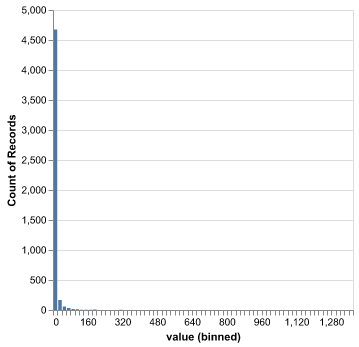

In [6]:
(
    alt.Chart(pop_lognormal_pd)
    .mark_bar()
    .encode(
        alt.X("value", bin=alt.Bin(maxbins=100)),
        alt.Y("count()")
    )
).show()

In [7]:
lognormal_sample = np.random.choice(pop_lognormal, size=100, replace=False)

In [8]:
lognormal_mean_sampling_distribution = get_sampling_distribution(
    input_sample=lognormal_sample,
    size=2000,
    summarising_fn=np.mean
)

lognormal_mean_sampling_distribution_pd = pd.DataFrame({"value": lognormal_mean_sampling_distribution})

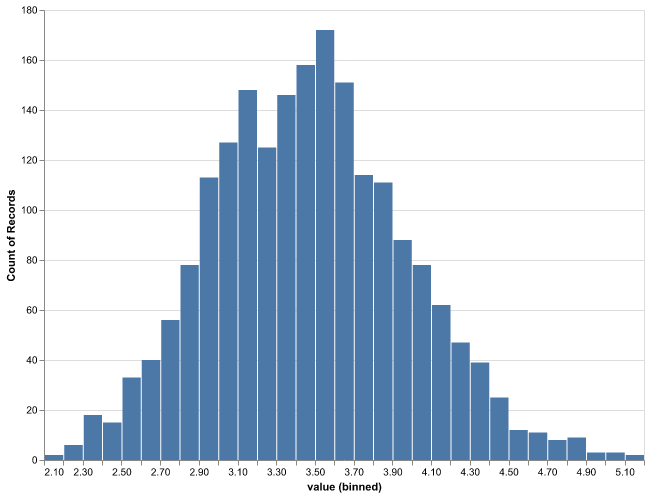

In [18]:
(
    alt.Chart(lognormal_mean_sampling_distribution_pd)
    .mark_bar()
    .encode(
        alt.X("value", bin=alt.Bin(maxbins=50)),
        alt.Y("count()")
    )
    .properties(
        width=600,
        height=450
    )
).show()

In [10]:
lognormal_median_sampling_distribution = get_sampling_distribution(
    input_sample=lognormal_sample,
    size=2000,
    summarising_fn=np.median
)

lognormal_median_sampling_distribution_pd = pd.DataFrame({"value": lognormal_median_sampling_distribution})

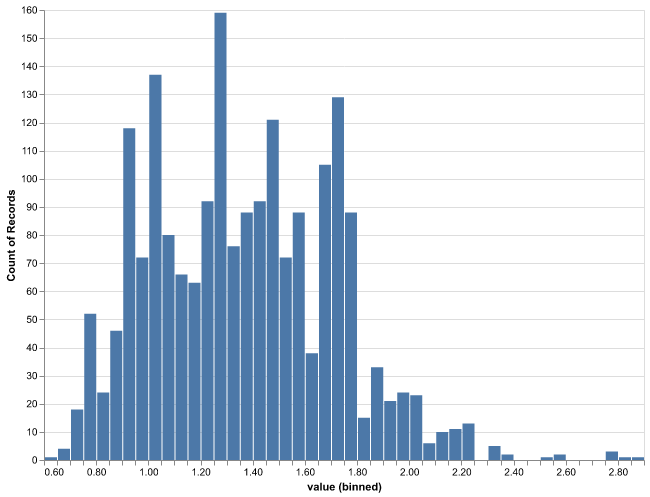

In [17]:
(
    alt.Chart(lognormal_median_sampling_distribution_pd)
    .mark_bar()
    .encode(
        alt.X("value", bin=alt.Bin(maxbins=50)),
        alt.Y("count()")
    )
    .properties(
        width=600,
        height=450
    )
).show()

In [12]:
lognormal_variance_sampling_distribution = get_sampling_distribution(
    input_sample=lognormal_sample,
    size=2000,
    summarising_fn=np.var
)

lognormal_variance_sampling_distribution_pd = pd.DataFrame({"value": lognormal_variance_sampling_distribution})

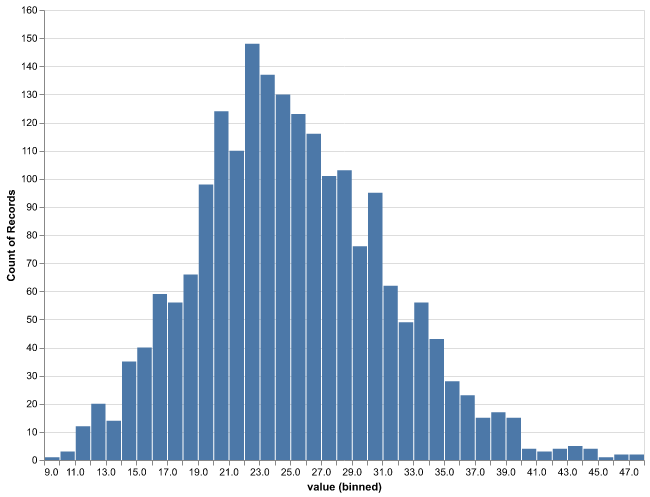

In [15]:
(
    alt.Chart(lognormal_variance_sampling_distribution_pd)
    .mark_bar()
    .encode(
        alt.X("value", bin=alt.Bin(maxbins=50)),
        alt.Y("count()")
    )
    .properties(
        width=600,
        height=450
    )
).show()

Probably the only sampling distribution that looks oddly different from normal is that of the median. Its distribution is skewed, and there appear to be several values that might count as ‘modes’. For this particular (re)sampling, there is one clear mode. However, this might be different when a different set of data points is generated.

I’m guessing that the sampling distribution of the variance looks similar to that of the mean because the way one calculates them is _broadly_ similar (only their numerators differ substantially).

From this example, we see that even if a raw distribution is ridiculously skewed, the sampling distribution of its mean would still take on a bell shape. The sampling distribution of the median, however, looks a little wonky.

In future I’d like to find a sample statistic whose distribution is decidedly non-normal.